In [1]:
# change to correct working directory
# %pwd
%cd ..
%pwd

/home/felix/bluebird/energy-aware-computing


'/home/felix/bluebird/energy-aware-computing'

In [2]:
# load the auto-reload extension
%load_ext autoreload
%autoreload 2

In [3]:
import hvplot
import hvplot.pandas
import holoviews as hv
from bokeh.models import HoverTool
from gpyjoules.util import TimestampInfo
from gpyjoules.new_analysis import *
import bokeh.themes
from pathlib import Path
import pandas as pd
import json
import numpy as np
import holoviews as hv
from holoviews import opts
import seaborn as sns
import statsmodels.formula.api as sm

In [4]:
def mse(df, column):
    return ((df[column] - df[f"{column}_hat"]) ** 2).mean()


def rmse(df, column):
    return np.sqrt(mse(df, column))

In [5]:
v100 = DataLoader("data/dgx11")
v100_pl = v100.experiments["power-limit"]
p_max = 300
f_max = 1530

In [6]:
def get_all_agg(exp):
    all_agg = []
    for bench in exp.benchmarks.values():
        print(bench.name)
        tmp = bench.aggregate("sd", None)#"mean")
        tmp["benchmark"] = bench.name
        all_agg.append(tmp)
    all_agg = pd.concat(all_agg)
    return all_agg

In [7]:
def plot_model(x,y,data,hue:str="benchmark"):
    sns.scatterplot(x=x,y=y,hue="benchmark", data=data)
    sns.lineplot(x=x,y=f"{y}_hat", data=data,hue=hue)#, style=list("xxxxxxxxxxxxxxx"), markers={"x":"x"}) ,hue="benchmark"

In [8]:
all_agg = get_all_agg(v100_pl)
#all_agg = all_agg[all_agg["benchmark"] != "nbody"]

mnist-dense
resnet
mnist-cnn
nbody
bert


In [9]:
all_agg = all_agg.rename(columns={"clock-gpu": "clock_gpu",
                                 "enforced-power-limit": "enforced_power_limit"})

In [10]:
all_agg["enforced_power_limit"] = all_agg["enforced_power_limit"] / 1_000

In [11]:
def get_activity_from_power(power, p_max):
    return power.loc[f"{p_max}W"].mean() / p_max

In [14]:
all_agg["p_util"] = all_agg.groupby("benchmark")["power"].transform(lambda power: get_activity_from_power(power=power, p_max=p_max))

all_agg["time_reference"] = all_agg.groupby("benchmark")["timestamp"].transform(lambda time: time.loc[f"{p_max}W"].mean())
all_agg["delay"] = all_agg["timestamp"] / all_agg["time_reference"]  #all_agg.groupby("benchmark")["timestamp"].transform(lambda time: time/time.loc["300W"].mean())

all_agg["energy_reference"] = all_agg.groupby("benchmark")["energy"].transform(lambda energy: energy.loc[f"{p_max}W"].mean())
all_agg["relative_energy"] = all_agg["energy"] / all_agg["energy_reference"]#all_agg.groupby("benchmark")["energy"].transform(lambda energy: energy/energy.loc["300W"].mean())

all_agg["relative_clock_gpu"] = all_agg["clock_gpu"] / f_max

all_agg["relative_power"] = np.clip(all_agg["enforced_power_limit"] / all_agg["p_util"], a_max=p_max, a_min=None)

In [15]:
def get_clock_model(training_data):
    return sm.ols(formula="relative_clock_gpu ~ relative_power", data=training_data).fit()

In [16]:
clock_model = get_clock_model(all_agg)
all_agg["clock_gpu_hat"] = clock_model.predict(all_agg) *  f_max
clock_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     relative_clock_gpu   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     4558.
Date:                Thu, 11 Feb 2021   Prob (F-statistic):          1.23e-138
Time:                        10:25:46   Log-Likelihood:                 512.50
No. Observations:                 200   AIC:                            -1021.
Df Residuals:                     198   BIC:                            -1014.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.3578      0.009     41.124      0.000       0.341       0.375
relative_power     0.0021   3.14e-05     67.509      0.000       0.002       0.002
==============================================================================
Omnibus:                        5.676   Durbin-Watson:                   0.311
Prob(Omnibus):                  0.059   Jarque-Bera (JB):                8.502
Skew:                           0.041   Prob(JB):                       0.0143
Kurtosis:                       4.007   Cond. No.                     1.82e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.82e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
all_test = []
for bench_name, test_data in all_agg.groupby("benchmark"):
    train_data = all_agg[all_agg["benchmark"] != bench_name]
    
    clock_model = get_clock_model(train_data)
    
    test_data["clock_gpu_hat"] = clock_model.predict(test_data) *  f_max
    all_test.append(test_data)

all_test = pd.concat(all_test)
#rmse(all_test, "clock_gpu")
all_agg["clock_gpu_hat"] = all_test["clock_gpu_hat"]

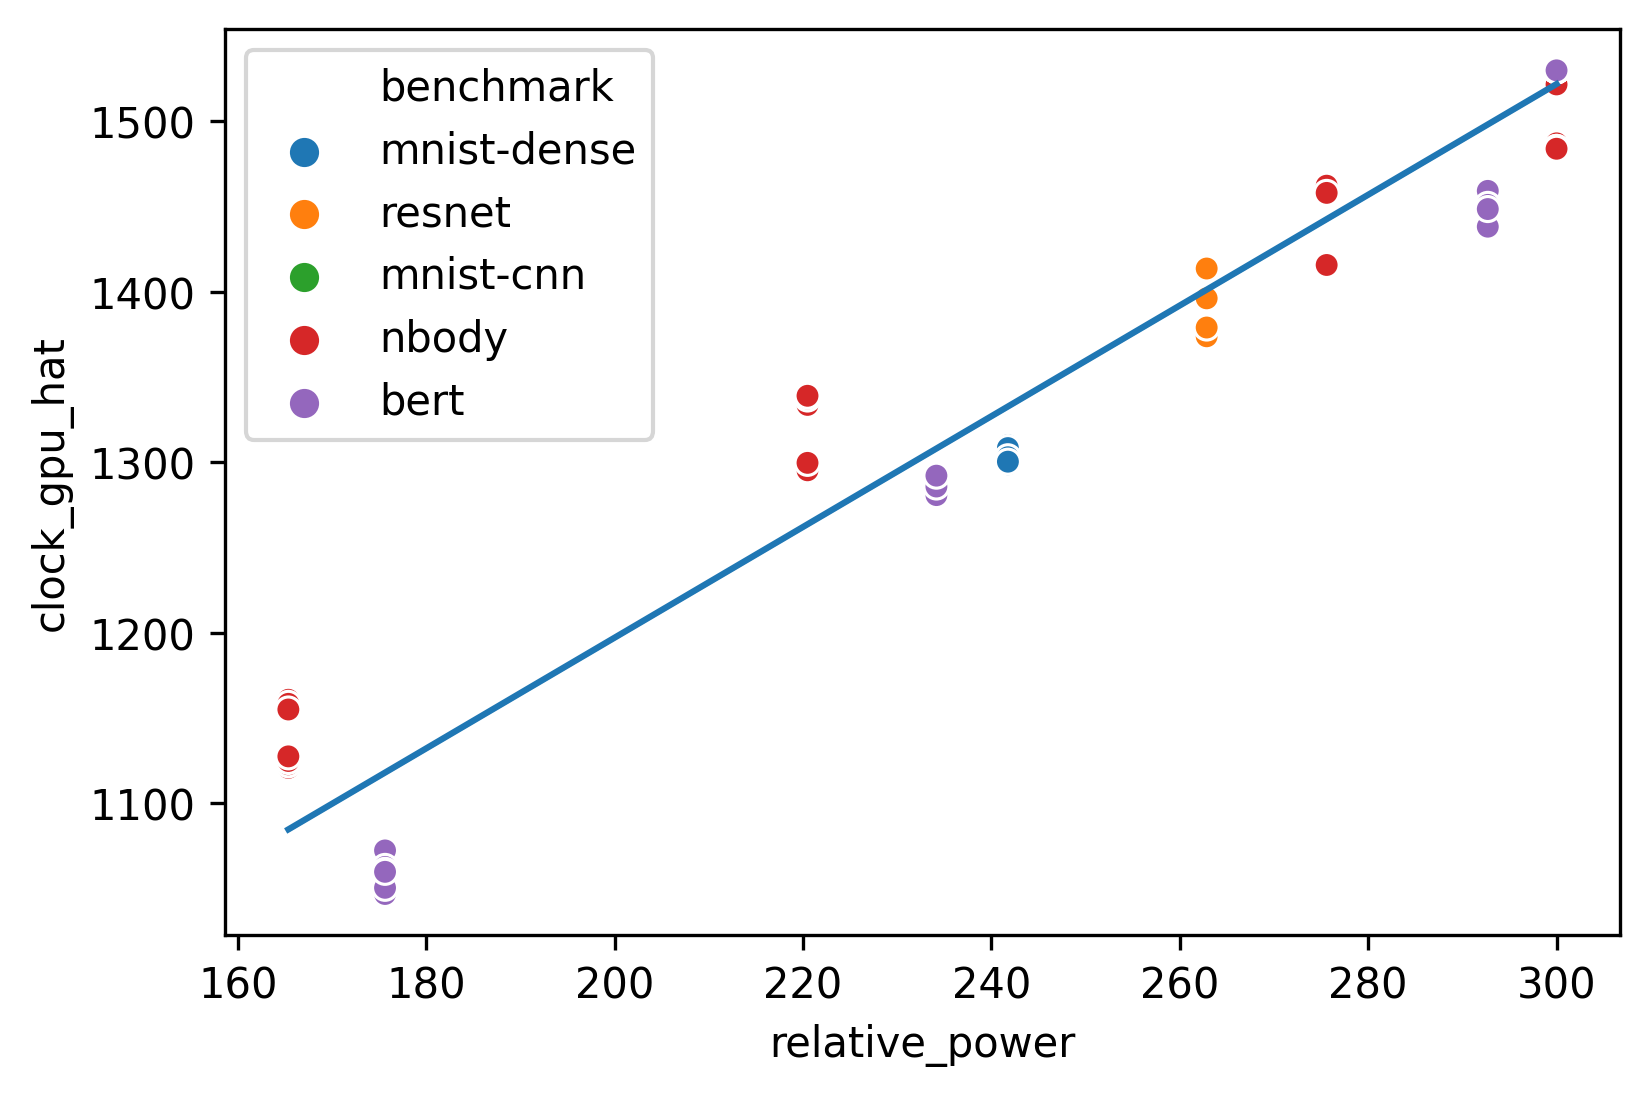

In [17]:
plot_model("relative_power", "clock_gpu", all_agg, hue=None)

In [18]:
def get_power_model(training_data):
    return sm.ols(formula="power ~ p1 +p2 +p3", data=training_data).fit()

In [19]:
all_agg["p1"] =  all_agg["p_util"] * all_agg["clock_gpu_hat"] ** 3
all_agg["p2"] =  all_agg["p_util"] * all_agg["clock_gpu_hat"] ** 2
all_agg["p3"] =  all_agg["p_util"] * all_agg["clock_gpu_hat"]

In [20]:
power_model = get_power_model(all_agg)
all_agg["power_hat"] = power_model.predict(all_agg)
power_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  power   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     5550.
Date:                Thu, 11 Feb 2021   Prob (F-statistic):          3.09e-189
Time:                        10:26:26   Log-Likelihood:                -583.58
No. Observations:                 200   AIC:                             1175.
Df Residuals:                     196   BIC:                             1188.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.0717      1.478      2.079      0.039       0.158       5.986
p1          1.222e-07   2.05e-08      5.949      0.000    8.17e-08    1.63e-07
p2            -0.0002   5.49e-05     -3.952      0.000      -0.000      -0.000
p3             0.2390      0.036      6.551      0.000       0.167       0.311
==============================================================================
Omnibus:                       40.282   Durbin-Watson:                   0.776
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.879
Skew:                          -1.052   Prob(JB):                     1.82e-15
Kurtosis:                       4.929   Cond. No.                     9.58e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.58e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

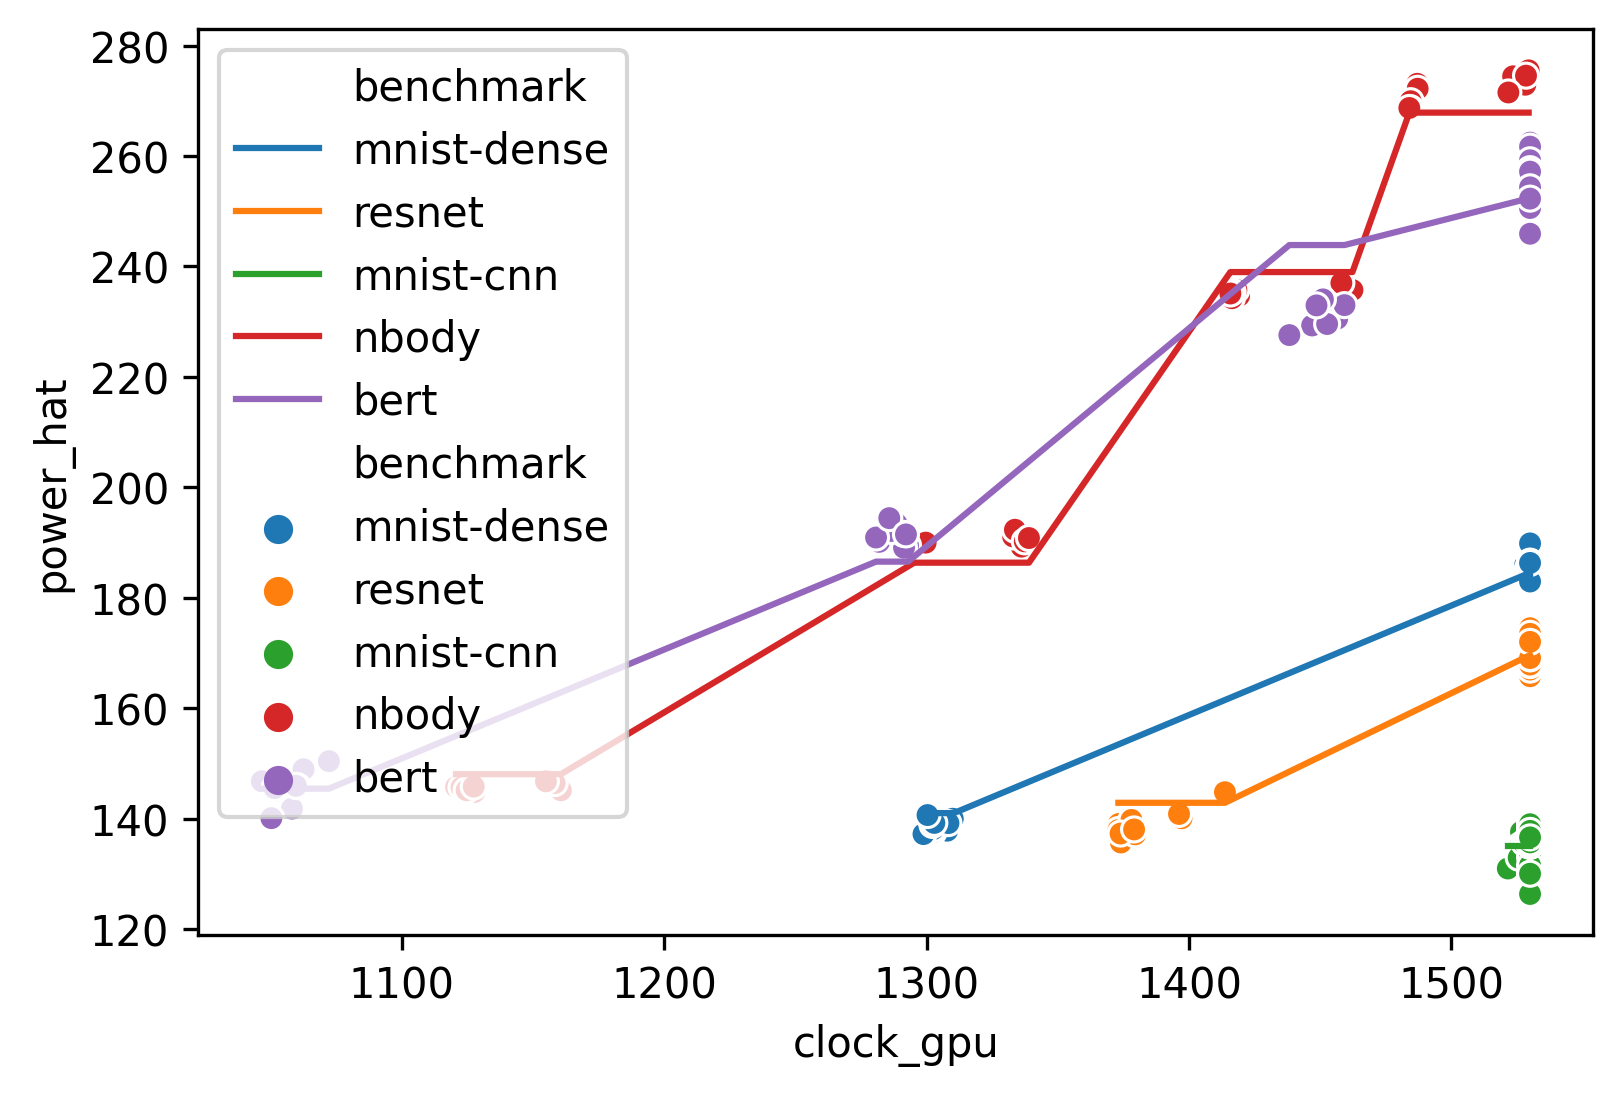

In [21]:
plot_model("clock_gpu","power",  all_agg, hue="benchmark")

In [172]:
all_test = []
for bench_name, test_data in all_agg.groupby("benchmark"):
    train_data = all_agg[all_agg["benchmark"] != bench_name]
    
    power_model = get_power_model(train_data)
    
    test_data["power_hat"] = power_model.predict(test_data)
    all_test.append(test_data)

all_test = pd.concat(all_test)
all_agg["power_hat"] = all_test["power_hat"]

In [22]:
def get_delay_model(training_data):
    return sm.ols(formula="delay ~ d1", data=all_agg).fit()

In [23]:
all_agg["d1"] = 1 / all_agg["clock_gpu_hat"]

In [24]:
delay_model = get_delay_model(all_agg)
all_agg["delay_hat"] = delay_model.predict(all_agg)
all_agg["time_hat"] =  all_agg["time_reference"] * all_agg["delay_hat"]
all_agg["energy_hat"] = (all_agg["power_hat"] * all_agg["time_hat"]) / 1_000

In [25]:
delay_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  delay   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     2471.
Date:                Thu, 11 Feb 2021   Prob (F-statistic):          8.41e-114
Time:                        10:27:38   Log-Likelihood:                 460.82
No. Observations:                 200   AIC:                            -917.6
Df Residuals:                     198   BIC:                            -911.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2882      0.015     18.746      0.000       0.258       0.318
d1          1078.5572     21.696     49.713      0.000    1035.773    1121.341
==============================================================================
Omnibus:                       35.670   Durbin-Watson:                   0.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.964
Skew:                           0.813   Prob(JB):                     4.33e-18
Kurtosis:                       5.637   Cond. No.                     1.26e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

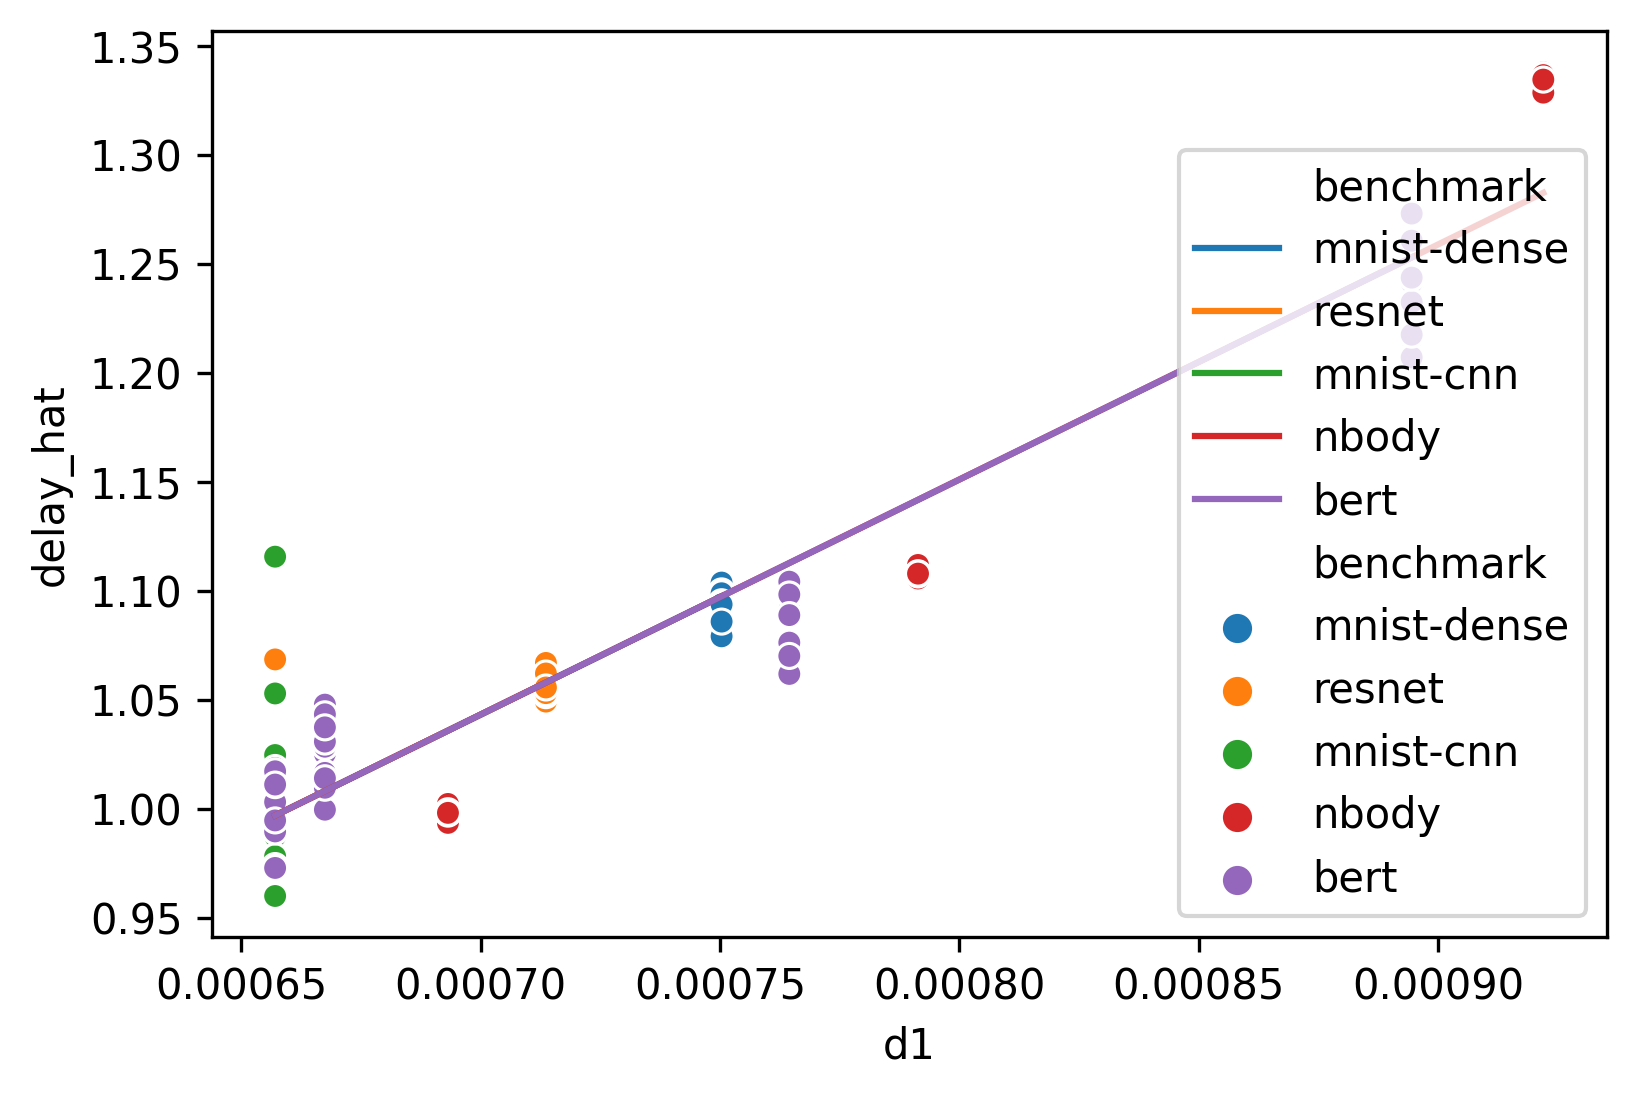

In [26]:
plot_model("d1", "delay",  all_agg, hue="benchmark")

In [148]:
all_test = []
for bench_name, test_data in all_agg.groupby("benchmark"):
    train_data = all_agg[all_agg["benchmark"] != bench_name]
    
    delay_model = get_delay_model(all_agg)
    
    test_data["delay_hat"] = delay_model.predict(test_data)
    all_test.append(test_data)

all_test = pd.concat(all_test)
all_agg["delay_hat"] = all_test["delay_hat"]
all_agg["time_hat"] =  all_agg["time_reference"] * all_agg["delay_hat"]
all_agg["energy_hat"] = (all_agg["power_hat"] * all_agg["time_hat"]) / 1_000

In [38]:
rmse(all_agg, "clock_gpu")

29.409913771467178

<AxesSubplot:xlabel='enforced_power_limit', ylabel='clock_gpu'>

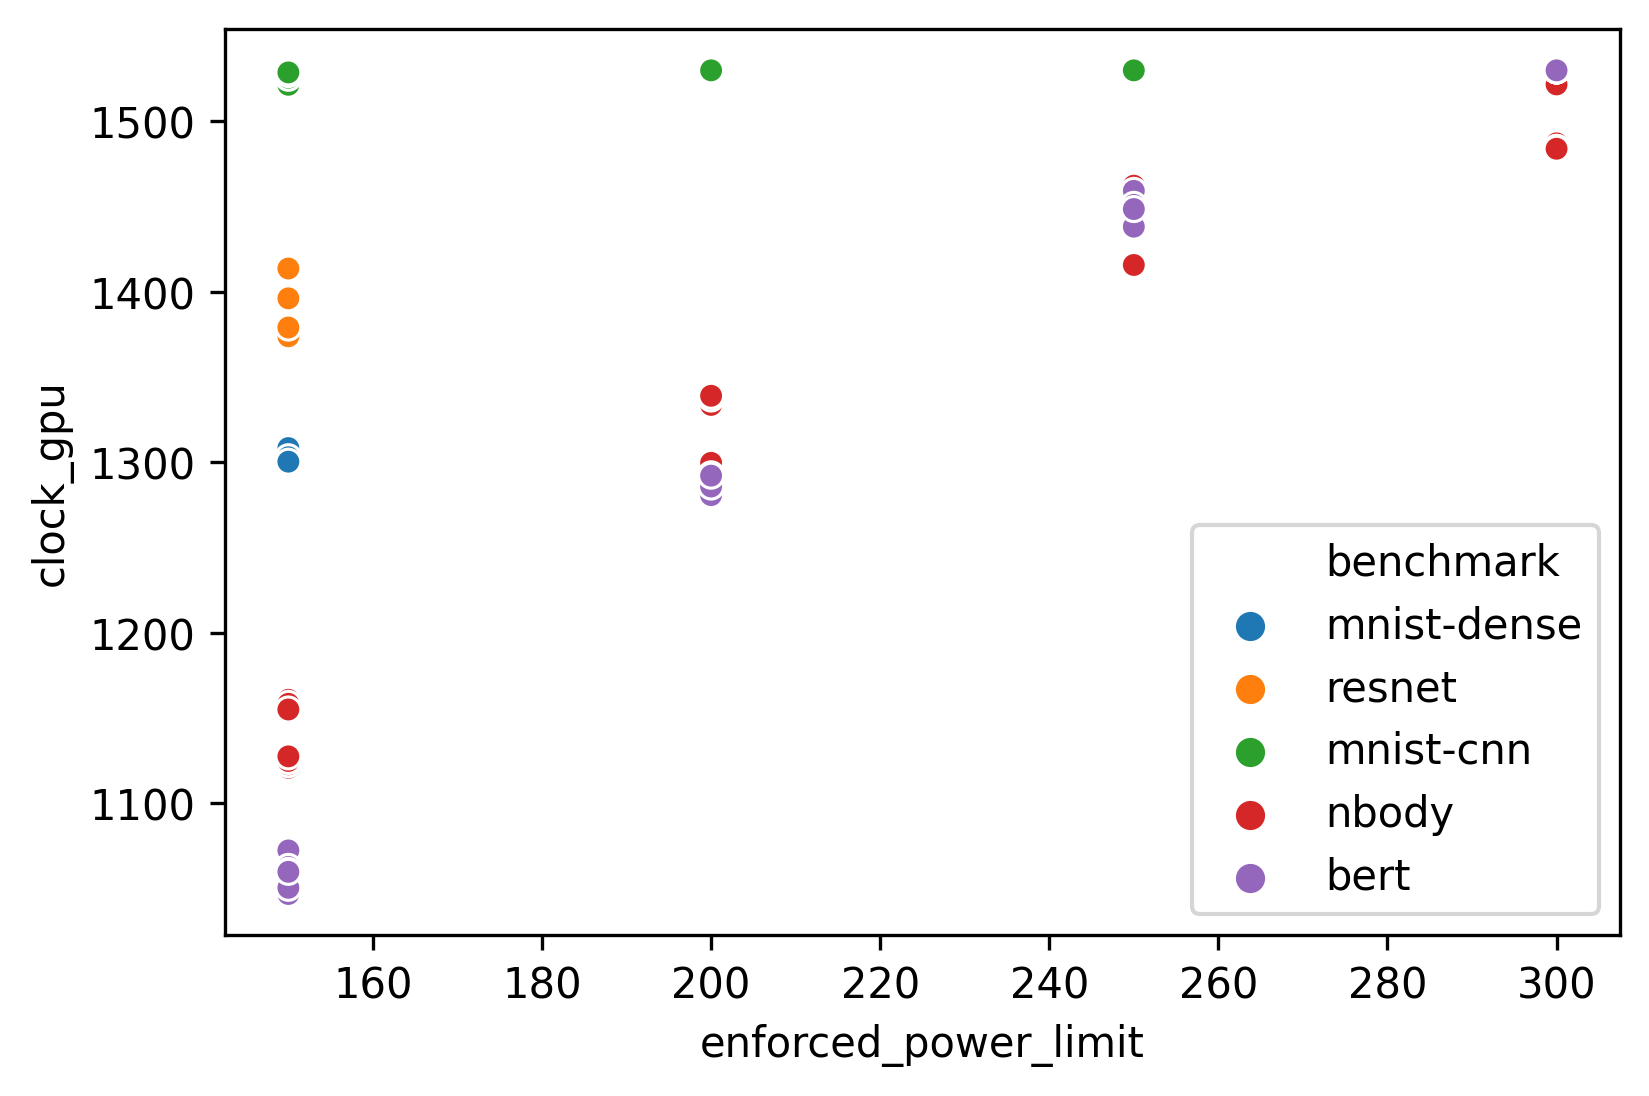

In [40]:
sns.scatterplot(x="enforced_power_limit",y="clock_gpu",hue="benchmark", data=all_agg)

<AxesSubplot:xlabel='enforced_power_limit', ylabel='energy_hat'>

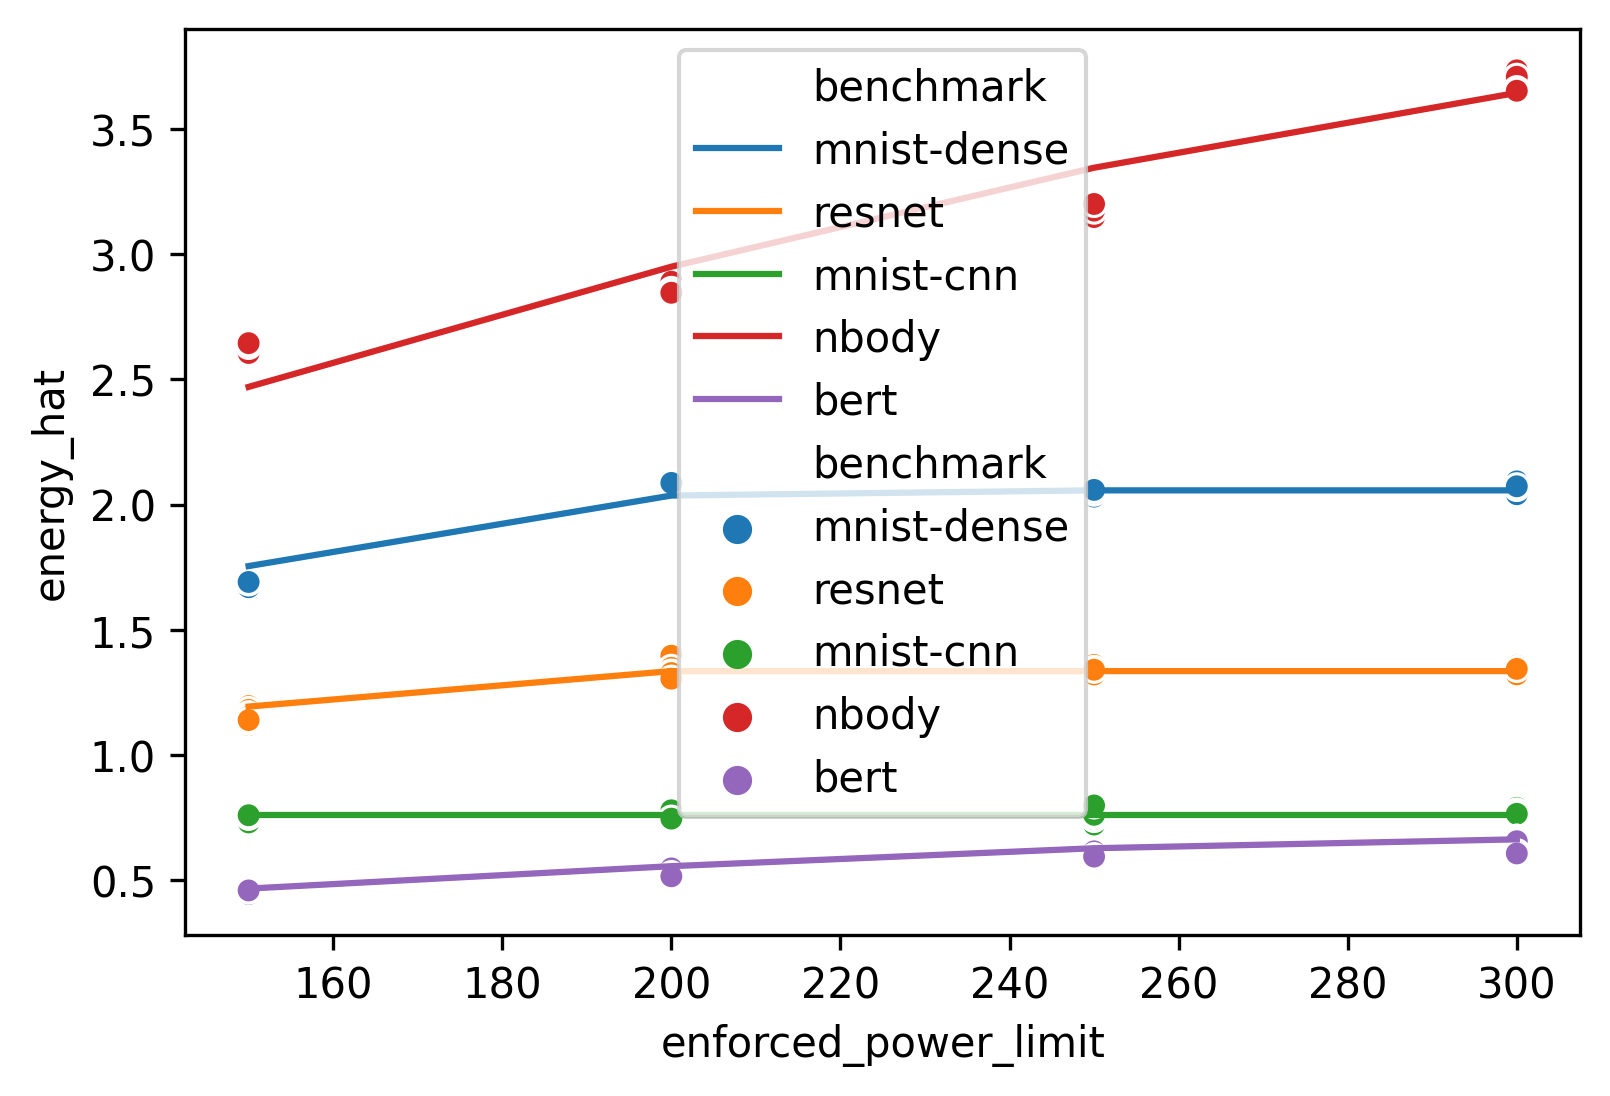

In [43]:
sns.scatterplot(x="enforced_power_limit",y="energy",hue="benchmark", data=all_agg)
#all_agg["clock_gpu_piecewise"] = np.interp(all_agg["enforced_power_limit"],all_agg["enforced_power_limit"], all_agg["clock_gpu"])
#sns.lineplot(x="enforced_power_limit",y="clock_gpu_piecewise",hue="benchmark", data=all_agg)
sns.lineplot(x="enforced_power_limit",y="energy_hat",hue="benchmark", data=all_agg)

In [154]:
#all_agg["clock3"] =  all_agg["clock_gpu"] ** 2# 1.8 #all_agg["p_util"] *
#all_agg["p1"] =  all_agg["p_util"] * all_agg["clock_gpu"] ** 3# 1.8 #all_agg["p_util"] *
#all_agg["p2"] =  all_agg["p_util"] * all_agg["clock_gpu"] ** 2
#all_agg["p3"] =  all_agg["p_util"] * all_agg["clock_gpu"]

In [155]:
#all_agg["clock3"] =  all_agg["clock_gpu"] ** 2# 1.8 #all_agg["p_util"] *
# 1.8 #all_agg["p_util"] *
all_agg["p1"] =  all_agg["p_util"] * all_agg["clock_gpu_hat"] ** 3
all_agg["p2"] =  all_agg["p_util"] * all_agg["clock_gpu_hat"] ** 2
all_agg["p3"] =  all_agg["p_util"] * all_agg["clock_gpu_hat"]

#all_agg["clock3"] =  all_agg["p_util"] * all_agg["clock_gpu"] ** 3 

#result = sm.ols(formula="power ~ clock3", data=all_agg#.groupby(["benchmark", "run"]).mean()
#               ).fit()


power_model = sm.ols(formula="power ~ p1 +p2 +p3", data=all_agg#[all_agg["benchmark"] != "resnet"]
            #.groupby(["benchmark", "run"]).mean()
               ).fit()
#result = sm.ols(formula="energy ~ clock3 + C(benchmark)", data=all_agg).fit()
#result = sm.ols(formula="energy ~  epl23 + C(benchmark)", data=all_agg).fit()

In [156]:
power_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  power   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     173.4
Date:                Wed, 10 Feb 2021   Prob (F-statistic):           6.66e-55
Time:                        00:46:02   Log-Likelihood:                -899.37
No. Observations:                 200   AIC:                             1807.
Df Residuals:                     196   BIC:                             1820.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     44.1750      6.528      6.767      0.000      31.301      57.049
p1         -1.682e-07   8.86e-08     -1.899      0.059   -3.43e-07    6.49e-09
p2             0.0005      0.000      2.125      0.035    3.67e-05       0.001
p3            -0.2448      0.161     -1.521      0.130      -0.562       0.073
==============================================================================
Omnibus:                       31.727   Durbin-Watson:                   0.178
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.160
Skew:                          -0.997   Prob(JB):                     7.00e-10
Kurtosis:                       4.042   Cond. No.                     9.00e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  9e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [157]:
all_agg["pd1"] = 1 / all_agg["clock_gpu_hat"]
delay_model = sm.ols(formula="delay ~ pd1", data=all_agg#[all_agg["benchmark"] != "resnet"]
            #.groupby(["benchmark", "run"]).mean()
               ).fit()

In [158]:
delay_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  delay   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     194.8
Date:                Wed, 10 Feb 2021   Prob (F-statistic):           2.82e-31
Time:                        00:46:03   Log-Likelihood:                 269.19
No. Observations:                 200   AIC:                            -534.4
Df Residuals:                     198   BIC:                            -527.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4902      0.040     12.198      0.000       0.411       0.569
pd1          791.1551     56.685     13.957      0.000     679.371     902.939
==============================================================================
Omnibus:                       25.419   Durbin-Watson:                   0.238
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.924
Skew:                           0.895   Prob(JB):                     1.93e-07
Kurtosis:                       3.710   Cond. No.                     1.27e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.27e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [159]:
# all_agg["p1"] =  all_agg["p_util"] * all_agg["clock_gpu"] ** 3# 1.8 #all_agg["p_util"] *
# all_agg["p2"] =  all_agg["p_util"] * all_agg["clock_gpu"] ** 2
# all_agg["p3"] =  all_agg["p_util"] * all_agg["clock_gpu"] ** 1
# result = sm.ols(formula="energy ~ p1 +p2 +p3", data=all_agg#[all_agg["benchmark"] != "resnet"]
#             #.groupby(["benchmark", "run"]).mean()
#                ).fit()

In [160]:
def predict_n_residuals(df, column: str, model):
    df[f"{column}_hat"] =  model.predict(df)
    df[f"{column}_res"] = df[f"{column}_hat"] - df[str(column)]

In [53]:
predict_n_residuals(all_agg, "power", power_model)

In [54]:
predict_n_residuals(all_agg, "delay", delay_model)

In [123]:
predict_n_residuals(all_agg, "clock_gpu", clock_model)

In [55]:
all_agg["time_hat"] =  all_agg["time_ref"] * all_agg["delay_hat"]

In [56]:
all_agg["energy_hat"] = (all_agg["power_hat"] * all_agg["time_hat"]) / 1_000

<AxesSubplot:xlabel='energy', ylabel='energy_hat'>

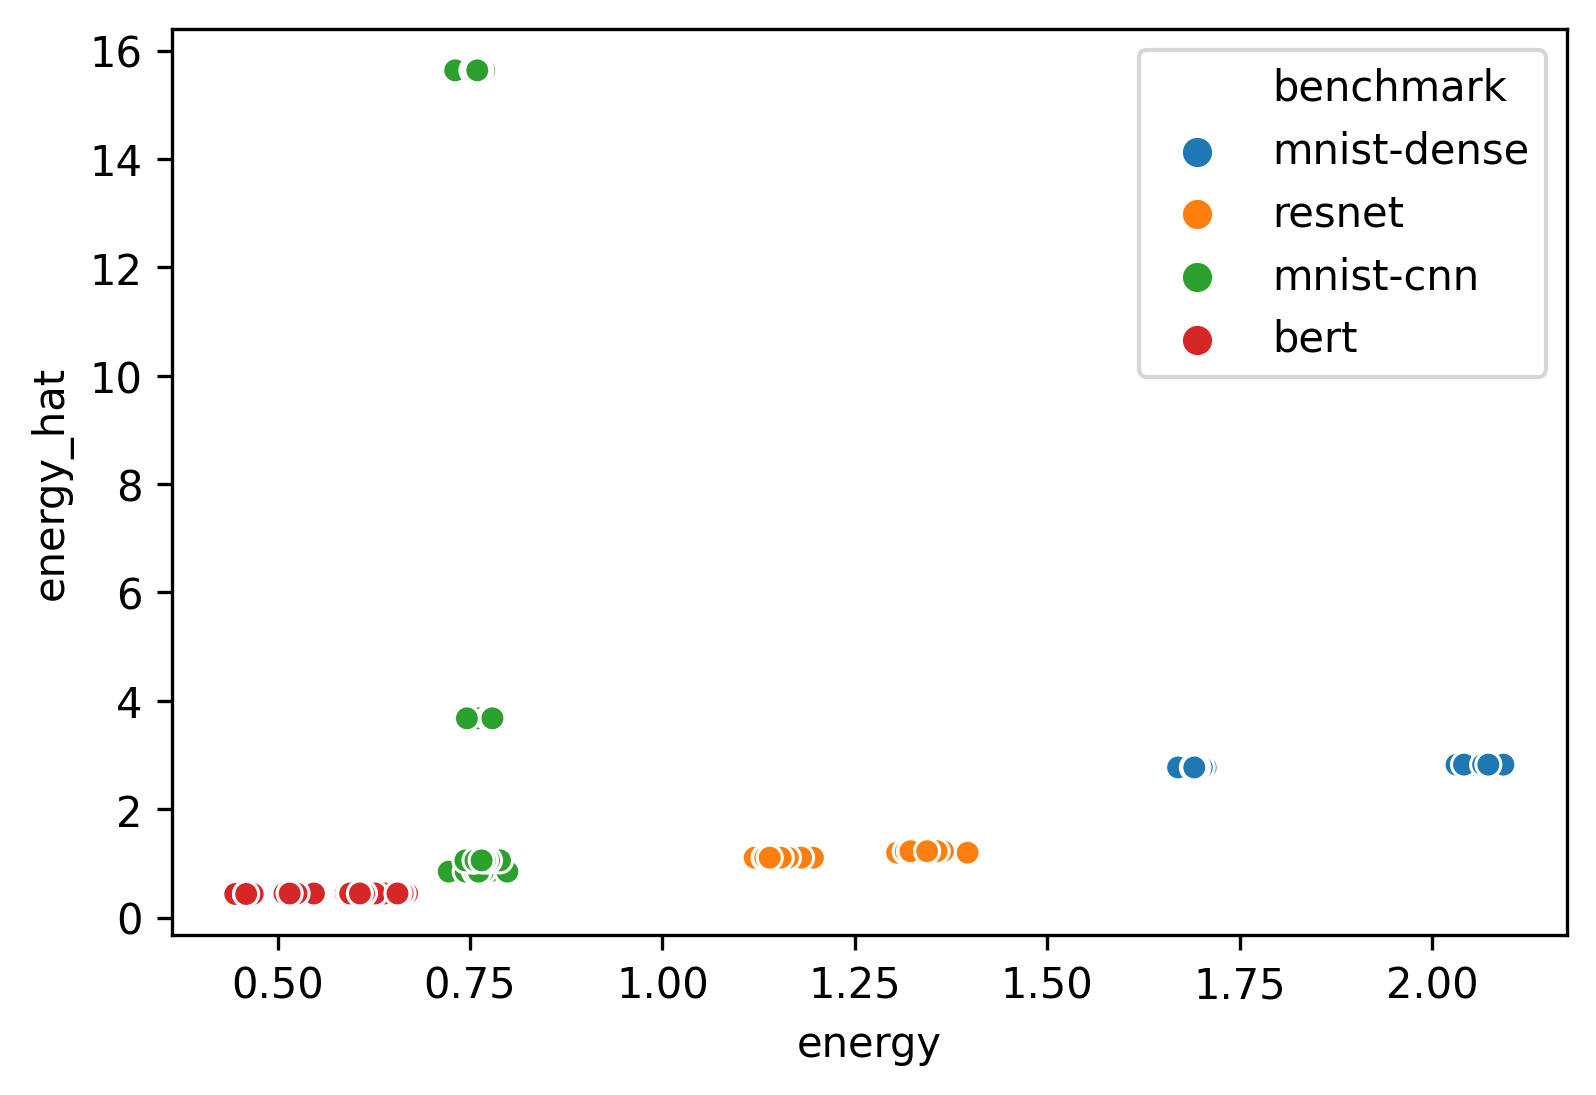

In [91]:
sns.scatterplot(x="energy",y="energy_hat",hue="benchmark", data=all_agg)

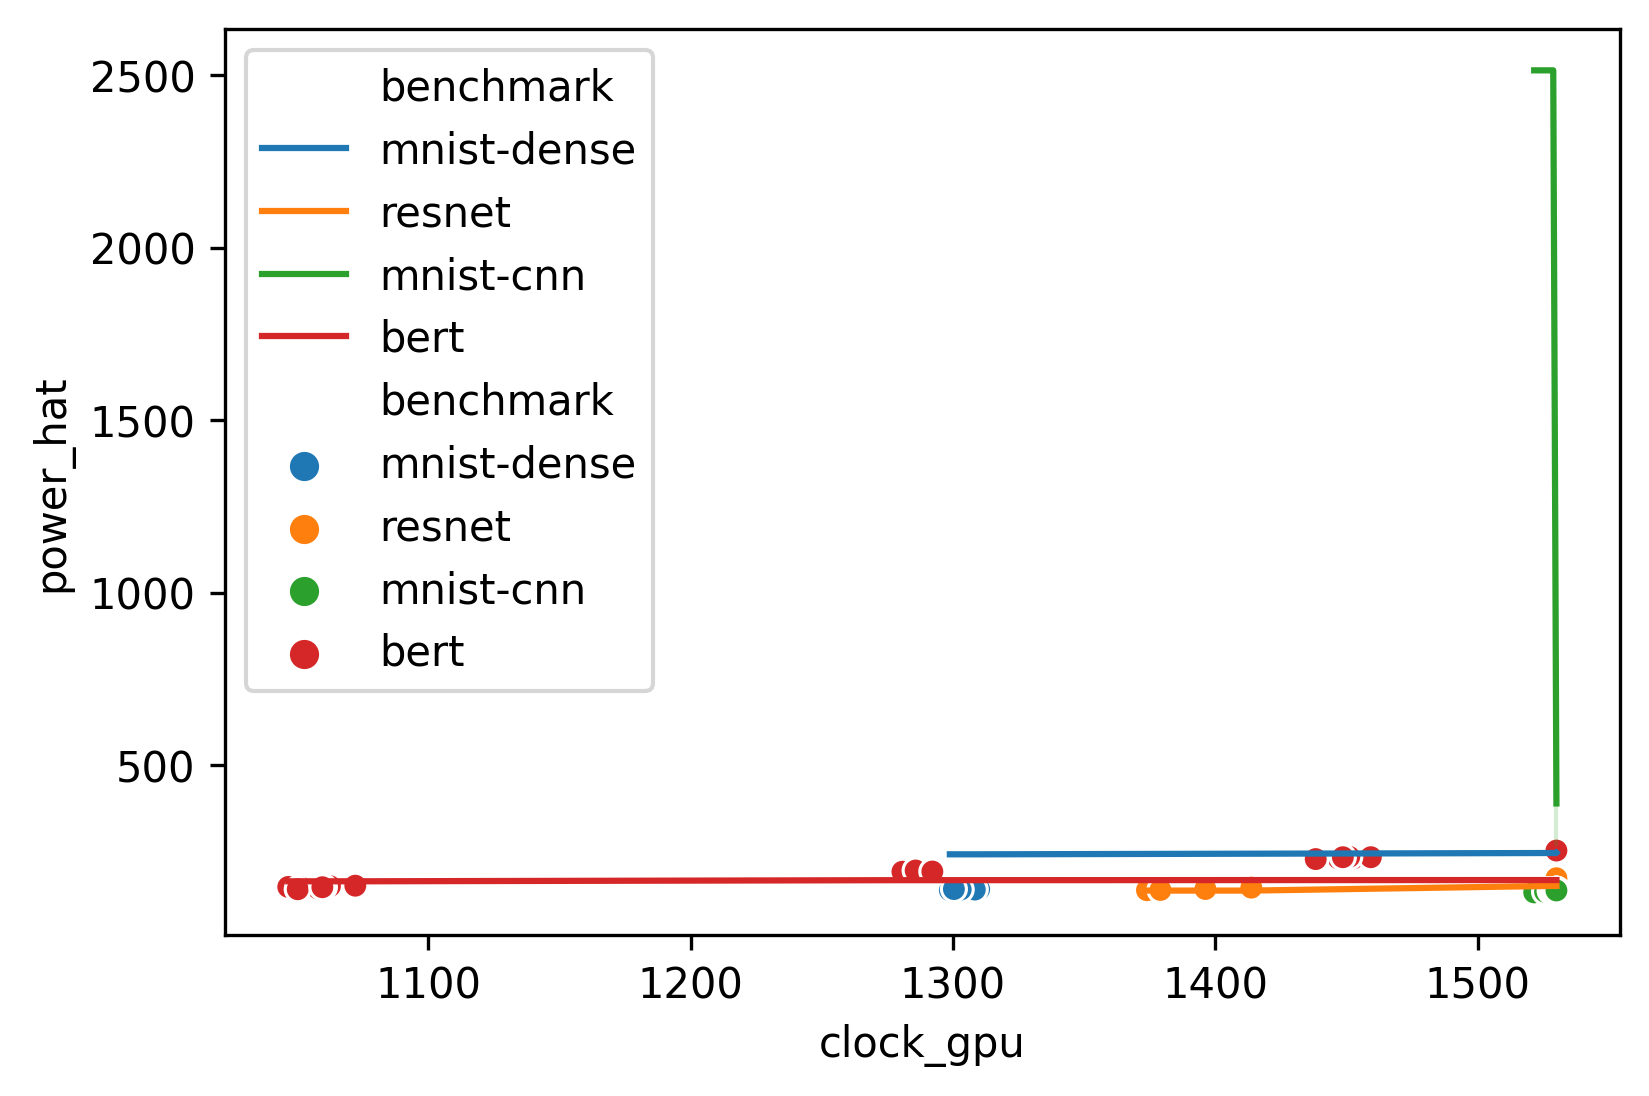

In [93]:
#sns.scatterplot(x="clock_gpu",y="power",hue="benchmark", data=all_agg)
#    sns.lineplot(x="clock_gpu",y="e_hat",hue="benchmark", data=all_agg)#, style=list("xxxxxxxxxxxxxxx"), markers={"x":"x"})
plot_model("clock_gpu", "power", all_agg)

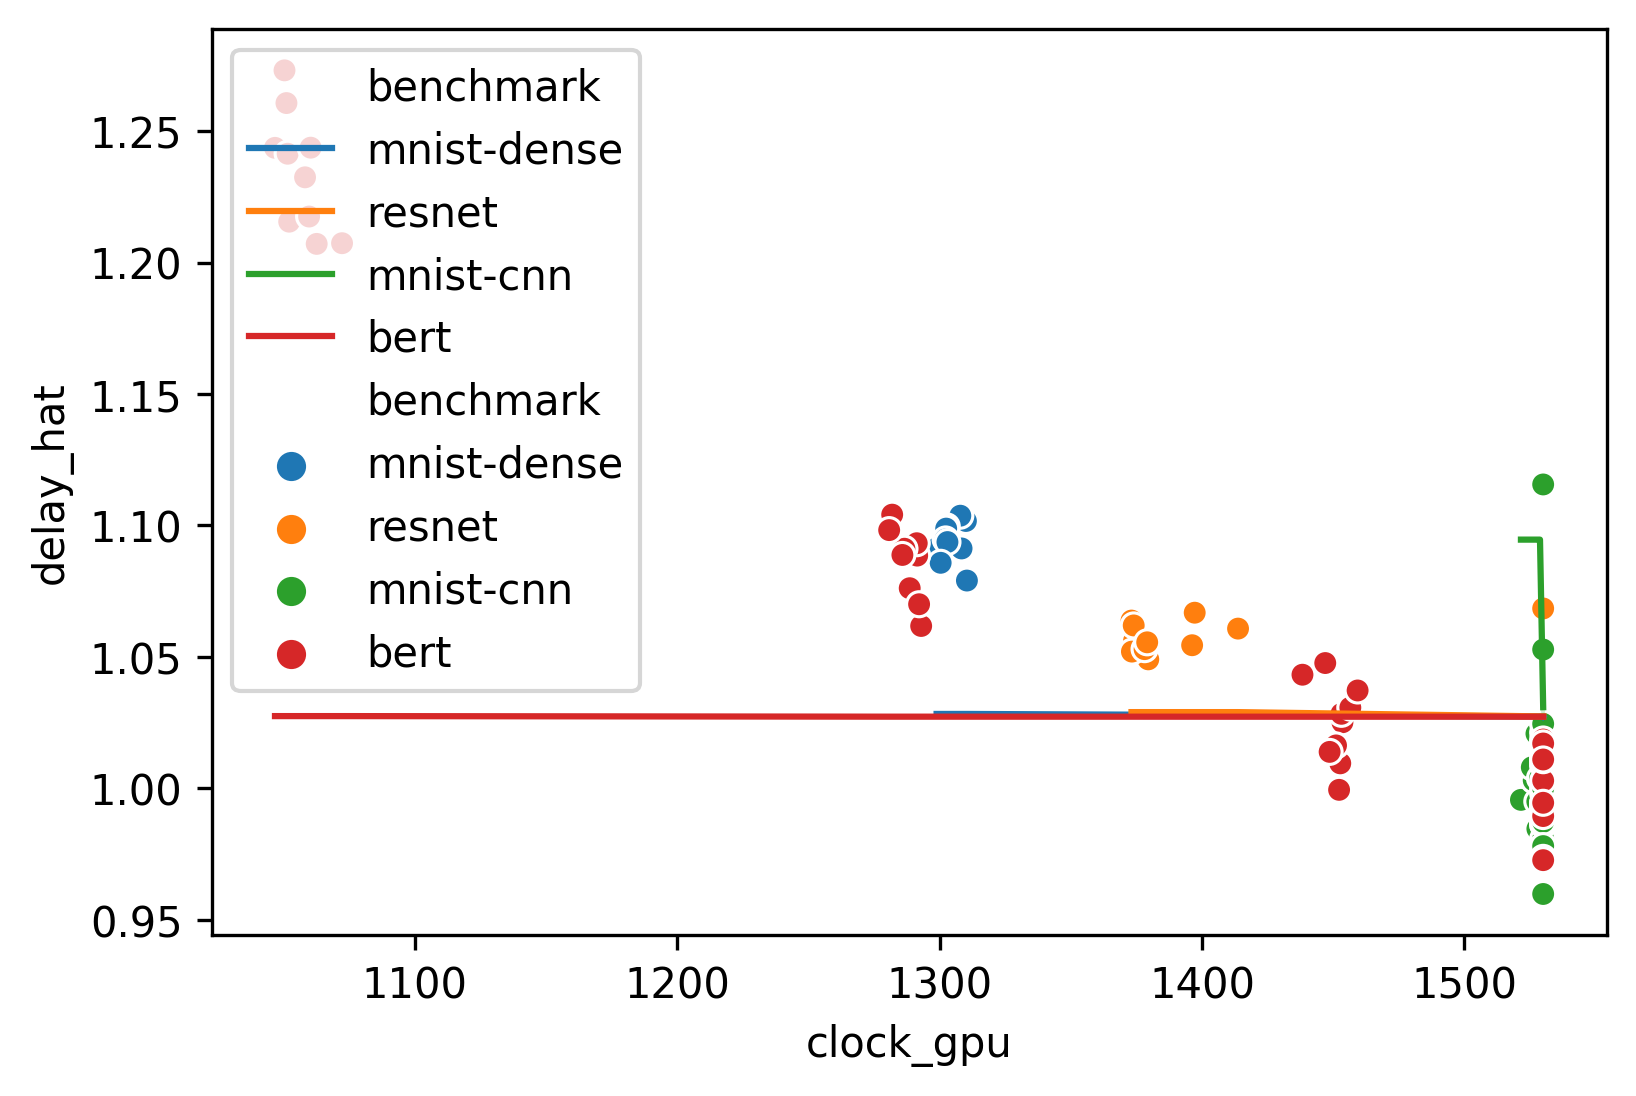

In [94]:
plot_model(x="clock_gpu", y="delay", data=all_agg)

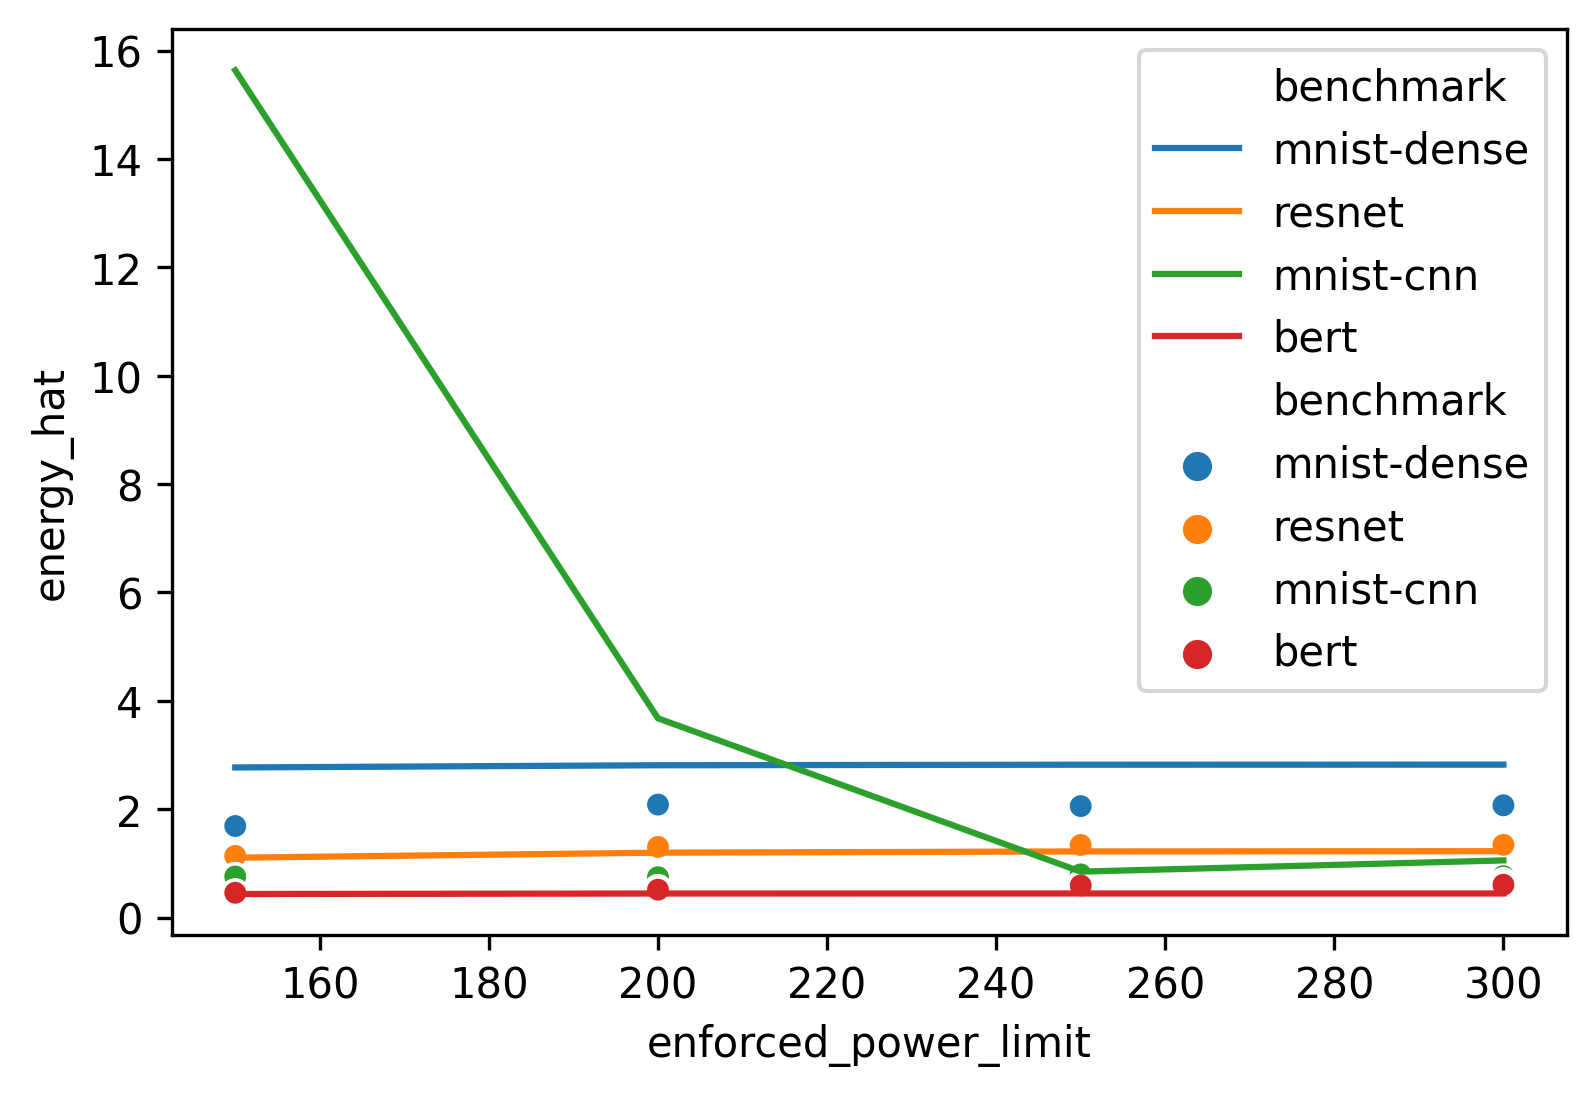

In [95]:
plot_model(x="enforced_power_limit", y="energy", data=all_agg)